In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

import re
import nltk
import string
import os

from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report

nltk.download('punkt')
nltk.download('stopwords')
os.environ["NLTK_DATA"] = "Users\\mvnik\\AppData\\Roaming\\nltk_data"




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mvnik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mvnik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
train_path = r"C:\Users\mvnik\Desktop\test_data.txt"
train_data = pd.read_csv(train_path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54200 non-null  int64 
 1   Genre        54200 non-null  object
 2   Description  54200 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
None


In [5]:
test_path = r"C:\Users\mvnik\Desktop\test_data.txt"
test_data = pd.read_csv(test_path, sep=':::', names=['Id', 'Title', 'Description'], engine='python')
test_data.head()

,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


In [6]:
print(train_data.describe())

              Title
count  54200.000000
mean   27100.500000
std    15646.336632
min        1.000000
25%    13550.750000
50%    27100.500000
75%    40650.250000
max    54200.000000


In [7]:
train_data.isnull().values.any()

False

C:\Users\mvnik\AppData\Local\Temp\ipykernel_27180\1580871604.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(h_pad=2.5)


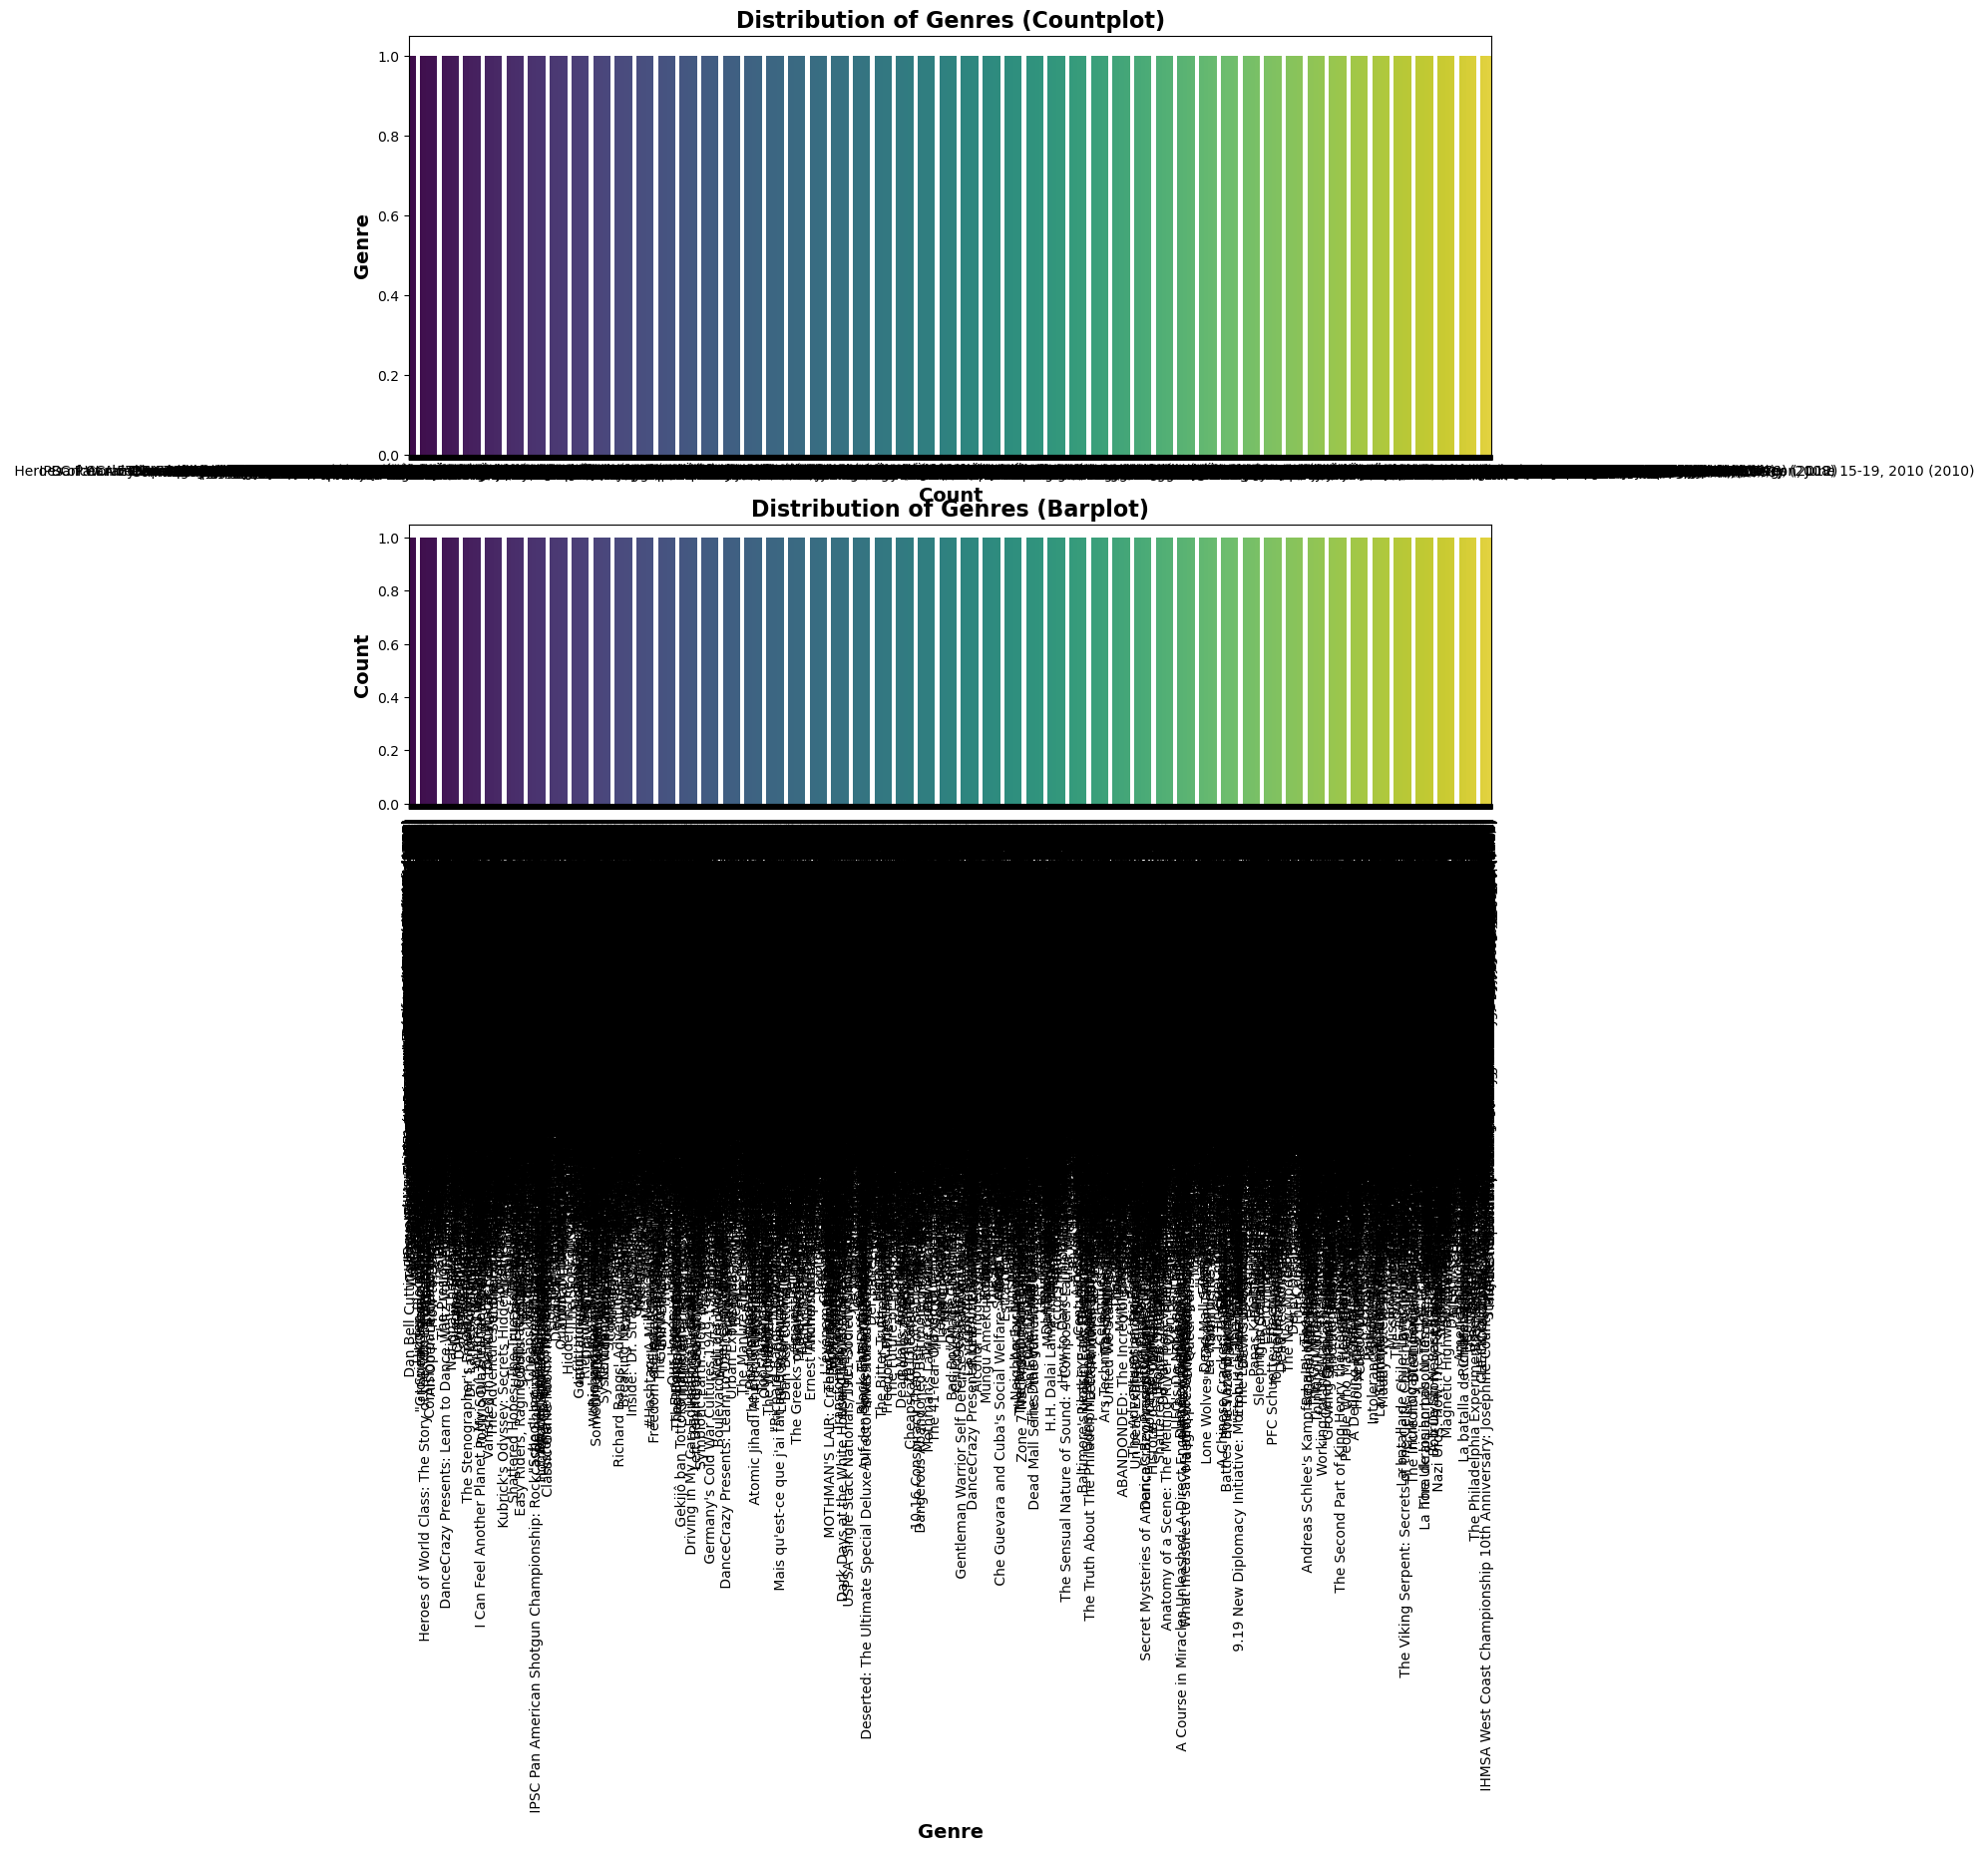

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure and axes with more space between subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 2]})

# Plotting countplot
sns.countplot(data=train_data, x='Genre', order=train_data['Genre'].value_counts().index, palette='viridis', ax=axes[0])
axes[0].set_xlabel('Count', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Genre', fontsize=14, fontweight='bold')
axes[0].set_title('Distribution of Genres (Countplot)', fontsize=16, fontweight='bold')

# Plotting barplot
counts = train_data['Genre'].value_counts()
sns.barplot(x=counts.index, y=counts, palette='viridis', ax=axes[1])
axes[1].set_xlabel('Genre', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=14, fontweight='bold')
axes[1].set_title('Distribution of Genres (Barplot)', fontsize=16, fontweight='bold')
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

# Adjust layout to prevent overlap and provide more space
plt.tight_layout(h_pad=2.5)

# Show the plots
plt.show()


In [9]:
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords

# Initialize stemmer and stop words
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

# Define the clean_text function
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    
    words = nltk.word_tokenize(text)
    
    # Remove stopwords and apply stemming
    words = [stemmer.stem(word) for word in words if word.lower() not in stop_words and len(word) > 2]
    
    # Join the cleaned words
    cleaned_text = ' '.join(words)
    
    return cleaned_text

# Apply clean_text function to 'Description' column in train_data and test_data
train_data['Text_cleaning'] = train_data['Description'].apply(clean_text)
test_data['Text_cleaning'] = test_data['Description'].apply(clean_text)


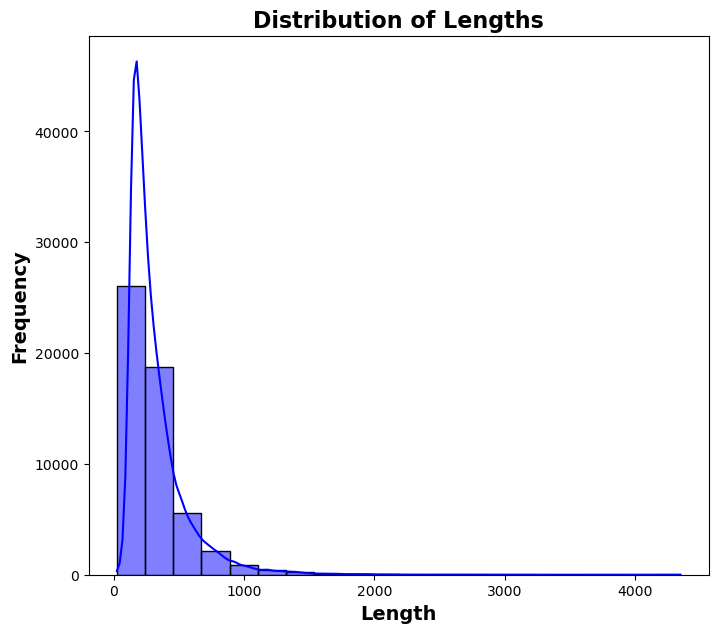

In [10]:
# Calculate the length of cleaned text
train_data['length_Text_cleaning'] = train_data['Text_cleaning'].apply(len)
# Visualize the distribution of text lengths
plt.figure(figsize=(8, 7))
sns.histplot(data=train_data, x='length_Text_cleaning', bins=20, kde=True, color='blue')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()

In [11]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(train_data['Text_cleaning'])

# Transform the test data
X_test = tfidf_vectorizer.transform(test_data['Text_cleaning'])

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'Text_cleaning' column contains preprocessed text
X = train_data['Text_cleaning']
y = train_data['Genre']

# Reshape X_train to have two dimensions
X_train = X_train.values.reshape(-1, 1)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF with a sparse matrix
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)


In [39]:
test_data['Text_cleaning'] = test_data['Description'].apply(clean_text)

# Vectorize the text data using TF-IDF
X_test_tfidf = vectorizer.transform(test_data['Text_cleaning'])

# Ensure the vocabulary of the test vectorizer is the same as the training vectorizer
X_test_tfidf = X_test_tfidf[:, selected_features]


In [20]:
print("Number of features in training data:", X_train_tfidf.shape[1])
print("Number of features in test data:", X_test_tfidf.shape[1])

Number of features in training data: 65758
Number of features in test data: 65758


In [34]:
print("Shape of X_train:", X_train.shape)
print("Length of y_train:", len(y_train))

Shape of X_train: (43360,)
Length of y_train: 43360


In [46]:
# Convert text data to numerical features using TF-IDF vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Use MultiLabelBinarizer for label binarization
labelbin = MultiLabelBinarizer()
Y_train = labelbin.fit_transform(y_train)
Y_val = labelbin.transform(y_val)

# Initialize and train a Multinomial Naive Bayes classifier using MultiOutputClassifier
classifier = MultiOutputClassifier(MultinomialNB())
classifier.fit(X_train_tfidf, Y_train)

# Make predictions on the validation set
Y_val_pred = classifier.predict(X_val_tfidf)

# Evaluate the performance of the model
accuracy = accuracy_score(Y_val, Y_val_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(Y_val, Y_val_pred))


Validation Accuracy: 0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10840
           1       0.00      0.00      0.00       114
           2       0.57      0.00      0.01      1317
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00       146
           7       0.00      0.00      0.00       655
           8       1.00      1.00      1.00     10840
           9       1.00      1.00      1.00     10840
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00       274
          13       0.00      0.00      0.00       284
          14       0.00      0.00      0.00       258
          15       0.00      0.00      0.00       396
          16       0.70      1.00      0.83      7543
  

C:\Users\mvnik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mvnik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
# Assuming X_test is a list of raw text data
X_test_tfidf = vectorizer.transform(X_test)

# Use the trained model to make predictions on the test data
X_test_predictions = classifier.predict(X_test_tfidf)

# Assuming test_data is a DataFrame containing the original text data
test_data['Predicted_Genre'] = labelbin.inverse_transform(X_test_predictions)


In [49]:
test_data.to_csv('predicted_genres.csv', index=False)
print(test_data)

          Id                             Title  \
0          1             Edgar's Lunch (1998)    
1          2         La guerra de papá (1977)    
2          3      Off the Beaten Track (2010)    
3          4           Meu Amigo Hindu (2015)    
4          5                Er nu zhai (1955)    
...      ...                               ...   
54195  54196   "Tales of Light & Dark" (2013)    
54196  54197      Der letzte Mohikaner (1965)    
54197  54198              Oliver Twink (2007)    
54198  54199                Slipstream (1973)    
54199  54200        Curitiba Zero Grau (2010)    

                                             Description  \
0       L.R. Brane loves his life - his car, his apar...   
1       Spain, March 1964: Quico is a very naughty ch...   
2       One year in the life of Albin and his family ...   
3       His father has died, he hasn't spoken with hi...   
4       Before he was known internationally as a mart...   
...                                    